# Example ML pipeline using BODC data

A simple overview for retrieving data from a croissant file and training a simple machine learning model.

Jonathan Coney|NOC|joncon at noc dot ac dot uk

## Notebook overview

This

In [20]:
#import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from glob import glob
import os
import zipfile

from io import StringIO, BytesIO
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries

import mlcroissant as mlc

## Get & prepare data

In [13]:
def find_flag(val):
    #find flagged data
    if str(val)[-1] in ['M']:
        return 0
    return 1

def replace_bad(val):
    #parse flagged data
    if str(val)[-1] in ['M','N']:
        return np.nan
    return val

def make_datetime(d,t):
    #format separate columns as a datetime object
    dt = d+t
    return datetime.strptime(dt,"%Y/%m/%d%H.%M.%S")

def read_croissant(str_obj):
    if "PPSCZZ01" in str(str_obj):
        df = pd.read_csv(BytesIO(str_obj),skiprows=13,sep="[ ^]+",names=['row_num','date','time','pressure'],engine='python')
        df['qc_flag'] = df['pressure'].apply(find_flag)
        df['pressure'] = df['pressure'].apply(replace_bad).astype(float)
        df['datetime'] = df.apply(lambda x: make_datetime(x.date, x.time), axis=1)
        df['datetime'] = df['datetime'].dt.floor("Min")
      #  df['fname'] = filename.split('/')[1].replace('.dat','')
        return df
    

def read_data(filename):
    #read file
    with open (filename,'r') as f:
        data = f.read()
    #create df and 
    #limit ourselves to the same variable 
    if "PPSCZZ01" in data:
        df = pd.read_csv(filename,skiprows=13,sep="[ ^]+",names=['row_num','date','time','pressure'],engine='python')
        df['qc_flag'] = df['pressure'].apply(find_flag)
        df['pressure'] = df['pressure'].apply(replace_bad).astype(float)
        df['datetime'] = df.apply(lambda x: make_datetime(x.date, x.time), axis=1)
        df['datetime'] = df['datetime'].dt.floor("Min")
      
        #df['fname'] = filename.split('/')[1].replace('.dat','')
        return df
    return None

### Using croissant

In [15]:
ds = mlc.Dataset("shelfbpr_bodc.json")
dfs = []
for f in ds.records(record_set="default"):
    out = read_croissant(f['dat/content'])
    if out is not None:
        dfs.append(out)

### Manually

In [2]:
if not os.path.isdir('data'):
    os.mkdir('data')

    !wget "https://www.bodc.ac.uk/data/hosted_data_systems/sea_level/bpr/data/shelfbpr.zip"

    with zipfile.ZipFile("shelfbpr.zip", 'r') as zip_ref:
        zip_ref.extractall("data")

In [50]:
dfs = []
for f in glob("data/*"):
    out = read_data(f)
    if out is not None:
        dfs.append(out)

## Split into train and test sets

In [16]:
time_series = []
i=0
for df in dfs:
    try:
        df = TimeSeries.from_dataframe(df[['datetime','pressure']],time_col='datetime',freq='15min',value_cols='pressure',fillna_value=0)
        df = df.resample(freq='15min',method='interpolate')[1:]
        time_series.append(df)
    except:
        print('skipping',i)
    i=i+1

ERROR:darts.timeseries:ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='15min'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
ERROR:darts.timeseries:ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='15min'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
ERROR:darts.timeseries:ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='15min'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
ERRO

skipping 5
skipping 10
skipping 14
skipping 15
skipping 20
skipping 25


## Produce TimeSeries objects ready for darts

In [17]:
#Scale data too
scaler = Scaler()
scaled = scaler.fit_transform(time_series)

In [18]:
train_test_split = 0.8

split = int(train_test_split * len(scaled))
train = scaled[:split]
test = scaled[split:]

In [19]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=192, output_chunk_length=96, random_state=42)

model.fit(train, epochs=2, verbose=True)

/noc/users/joncon/api4ai/API4AI/ai-ml-demos/noc/api4ai_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/noc/users/joncon/api4ai/API4AI/ai-ml-demos/noc/api4ai_venv/lib/python3.11/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUD

Epoch 1: 100%|██████████| 12415/12415 [07:50<00:00, 26.39it/s, train_loss=0.00793] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 12415/12415 [07:50<00:00, 26.39it/s, train_loss=0.00793]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=192, output_chunk_length=96, random_state=42)

In [22]:
n=192
test_x,test_y = [],[]
for k in test:
    test_x.append(k[:-n])
    test_y.append(k[-n:])

In [23]:
preds = model.predict(series=test_x, n=n)
cvtd = scaler.inverse_transform(preds)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]

In [24]:
test_inverse = scaler.inverse_transform(test_x)
truth_inverse = scaler.inverse_transform(test_y)

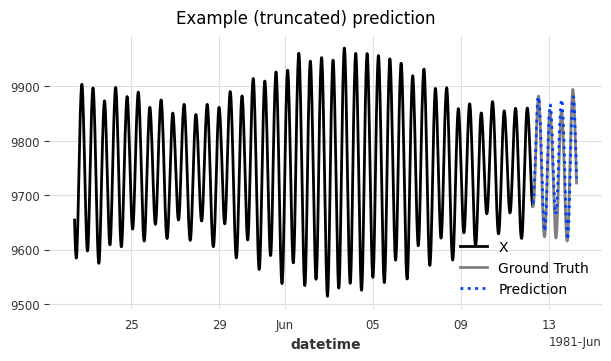

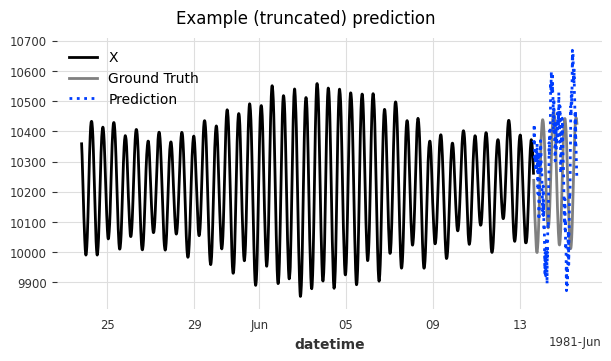

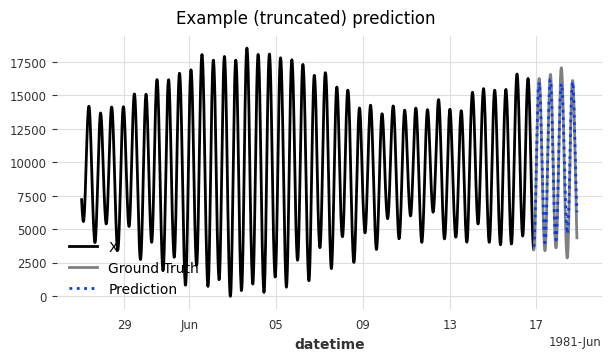

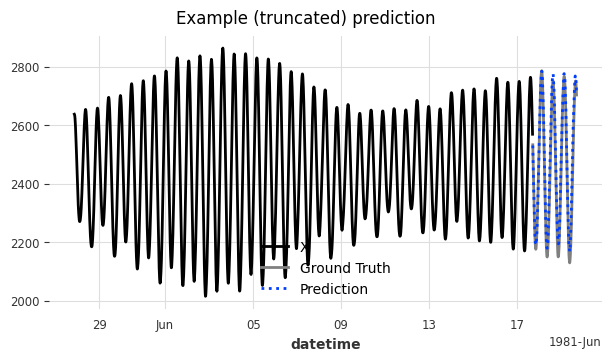

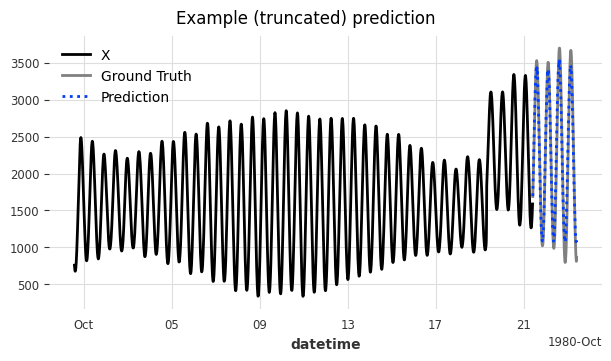

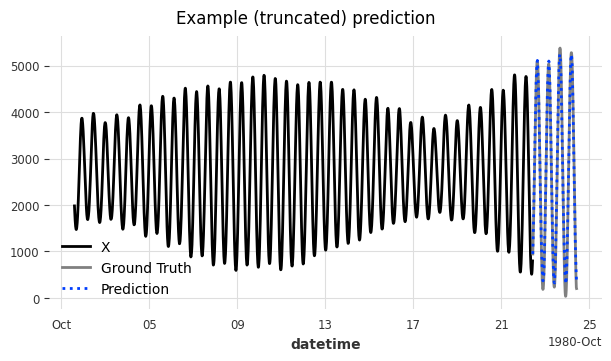

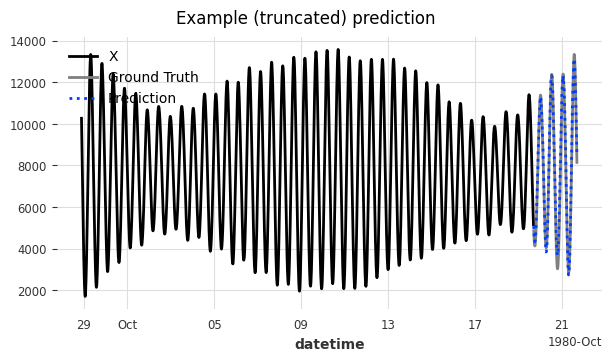

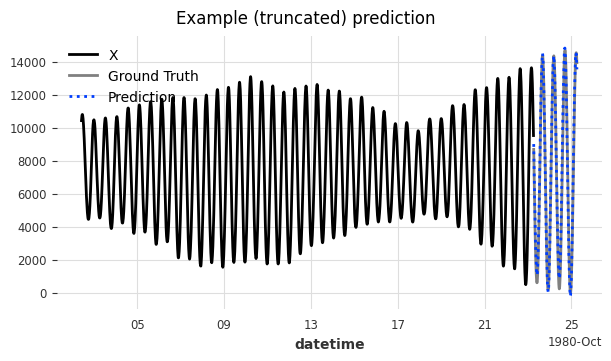

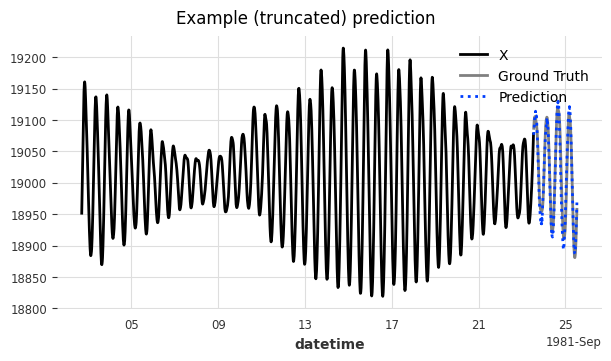

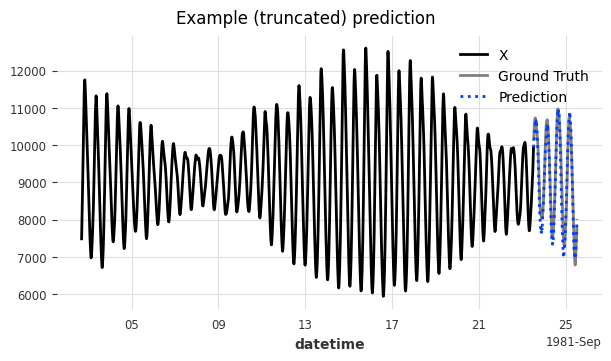

In [25]:
for item in range(len(test_inverse)):
    fig,ax = plt.subplots(figsize=(6,3.5),layout='constrained')
    test_inverse[item][-2000:].plot(ax=ax, label='X')
    truth_inverse[item].plot(ax=ax,linestyle='-',label='Ground Truth',color='grey')
    cvtd[item].plot(ax=ax,label='Prediction',linestyle=':')

    
    fig.suptitle('Example (truncated) prediction')

## Calculate skill

In [26]:
#Use RMSE to calculate prediction skill
from darts.metrics.metrics import rmse

#there's plenty others out there in various documentation: this is just an example from darts

rmses = rmse(truth_inverse,cvtd)
print(rmses)


[22.165887715563645, 257.0231515095178, 772.4010299063463, 30.576191688251654, 154.535390090198, 133.4345822661807, 297.46345020208463, 432.09960605309294, 12.331359712040234, 256.94151238413207]
